## This notebook contains various general functions on evolution of stock profile and representing different charts that can be used for further analysis

### Geometric Brownian motion of the stock evaluation is given by:-

### $ds_t = r*S_t*dt + \sigma*s_t*dZ_t$

### If we try to solve above equation using normal calculus, we will have different solution but the second component in above equation represent stochastic component meaning a brownian process (fluctuation around some mean and variance)

### variance of fluctuation is proportional to dt (st.dev is proportional to sqrt(dt) using iid assumption), thus it implies that we cannot ignore the second order derivative in the taylor series expansion which results in a significant dt component

### thus final solution to the equation is below

### $S_t = S_{t-\Delta t}*\exp((r - \sigma^2/2)*\Delta t + \sigma*\sqrt(\Delta t)*z_t)$

In [56]:
import math
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [71]:
def pdf_of_normal_dist(x, mu, sigma):
    normal_z = (x - mu) / sigma
    return np.exp(-0.5 * normal_z ** 2) / math.sqrt(2 * math.pi * sigma ** 2)

In [58]:
def simulate_gbm(s0, time_horizon, rf, vol, st_date, end_date):
    """
    function returns stock evaluation across dates based on parameters given as an argument
    """
    np.random.seed(250000) # so that I can repeat the same simulation
    df = pd.date_range(start=st_date, end=end_date, freq="B")
    time_steps = len(df)
    dt = 1 / 252 
    discount_factor = math.exp(-rf*dt) # single day discount factor
    
    rand_normal_matrix_for_dz = np.random.standard_normal((time_steps, 1))
    
    stock = np.zeros_like(rand_normal_matrix_for_dz) # same size for number of days
    stock[0] = s0
    
    
    for t in range(1, time_steps):
        stock[t] = stock[t-1] * np.exp((rf - vol**2/2)*dt + vol*np.sqrt(dt)*rand_normal_matrix_for_dz[t])
    
    gbm = pd.DataFrame(stock, index=df, columns=["index"])
    
    return gbm

In [59]:
stock_profile = simulate_gbm(100, 10, 0.05, 0.2, "01-01-2012", "01-01-2022")

In [60]:
def calculate_historical_annualized_vol_of_lognormal_returns(gbm):
    gbm['returns'] = np.log(gbm['index'] / gbm['index'].shift(1))
    
    # variance (multiplied by 252 to annualized it)
    gbm['realized_var'] = 252 * np.cumsum(gbm.returns**2) / np.arange(len(gbm))
    gbm['realized_vol'] = np.sqrt(gbm['realized_var'])
    gbm = gbm.dropna()
    
    return gbm

In [61]:
vol_returns = calculate_historical_annualized_vol_of_lognormal_returns(stock_profile)

In [82]:
# this method is copied from book
def print_statistics(data):
    print("RETURN SAMPLE STATISTICS")
    print("---------------------------------------------")
    print("Mean of Daily  Log Returns %9.6f" % np.mean(data['returns']))
    print("Mean of Annua. Log Returns %9.6f" %
          (np.mean(data['returns']) * 252))
    print("Std  of Annua. Log Returns %9.6f" %
          (np.std(data['returns']) * math.sqrt(252)))
    print("---------------------------------------------")
    print("Skew of Sample Log Returns %9.6f" % scs.skew(data['returns']))
    print("Skew Normal Test p-value   %9.6f" %
          scs.skewtest(data['returns'])[1])
    print("---------------------------------------------")
    print("Kurt of Sample Log Returns %9.6f" % scs.kurtosis(data['returns']))
    print("Kurt Normal Test p-value   %9.6f" %
          scs.kurtosistest(data['returns'])[1])
    print("---------------------------------------------")
    print("Normal Test p-value        %9.6f" %
          scs.normaltest(data['returns'])[1])
    print("---------------------------------------------")
    print("Realized Volatility        %9.6f" % data['realized_vol'].iloc[-1])
    print("Realized Variance          %9.6f" % data['realized_var'].iloc[-1])
    
    return

In [67]:
# quote charte plotted and correspoinding log returns
def quotes_returns(data):
    ''' Plots quotes and returns. '''
    plt.figure(figsize=(9, 6))
    plt.subplot(211)
    data['index'].plot()
    plt.ylabel('daily quotes')
    plt.grid(True)
    plt.axis('tight')

    plt.subplot(212)
    data['returns'].plot()
    plt.ylabel('daily log returns')
    plt.grid(True)
    plt.axis('tight')
    return

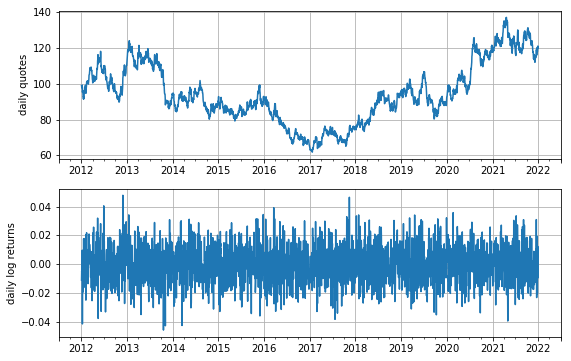

In [68]:
quotes_returns(vol_returns)

In [69]:
# histogram plot of log returns
def return_histogram(data):
    ''' Plots a histogram of the returns. '''
    plt.figure(figsize=(9, 5))
    x = np.linspace(min(data['returns']), max(data['returns']), 100)
    plt.hist(np.array(data['returns']), bins=50, normed=True)
    y = pdf_of_normal_dist(x, np.mean(data['returns']), np.std(data['returns']))
    plt.plot(x, y, linewidth=2)
    plt.xlabel('log returns')
    plt.ylabel('frequency/probability')
    plt.grid(True)
    return

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


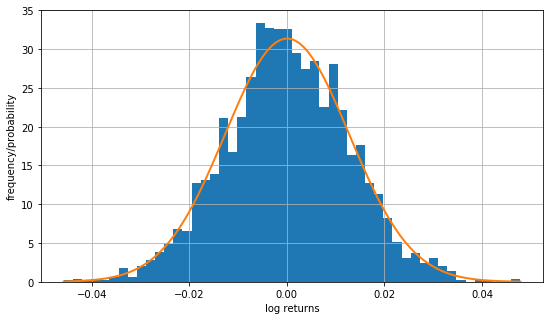

In [72]:
return_histogram(vol_returns)

In [73]:
## q-q plot to confirm normal distribution

def return_qqplot(data):
    ''' Generates a Q-Q plot of the returns.'''
    plt.figure(figsize=(9, 5))
    sm.qqplot(data['returns'], line='s')
    plt.grid(True)
    plt.xlabel('theoretical quantiles')
    plt.ylabel('sample quantiles')
    return

<Figure size 648x360 with 0 Axes>

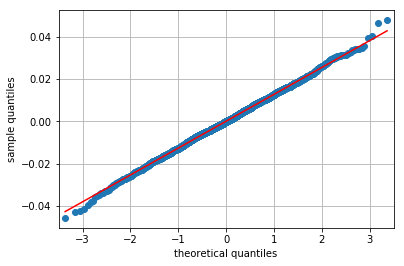

In [74]:
return_qqplot(vol_returns)

In [79]:
def realized_vol(data):
    plt.figure(figsize=(9, 6))
    data['realized_vol'].plot()
    plt.ylabel("Realized volatility")
    plt.grid(True)
    return

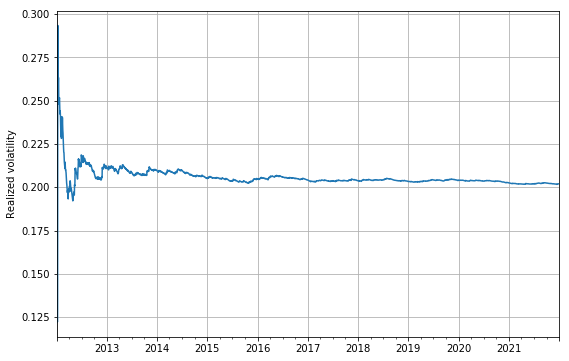

In [80]:
realized_vol(vol_returns)

In [83]:
print_statistics(vol_returns)

RETURN SAMPLE STATISTICS
---------------------------------------------
Mean of Daily  Log Returns  0.000070
Mean of Annua. Log Returns  0.017522
Std  of Annua. Log Returns  0.201926
---------------------------------------------
Skew of Sample Log Returns -0.015754
Skew Normal Test p-value    0.741831
---------------------------------------------
Kurt of Sample Log Returns  0.120584
Kurt Normal Test p-value    0.206531
---------------------------------------------
Normal Test p-value         0.426539
---------------------------------------------
Realized Volatility         0.201929
Realized Variance           0.040775


In [86]:
def rolling_statistics(data):
    '''
    Calculates and plots rolling statistics (mean, std, correlation). 
    All are annulazied again.
    '''
    plt.figure(figsize=(11, 8))

    plt.subplot(311)
    mr = data['returns'].rolling(252).mean() * 252
    mr.plot()
    plt.grid(True)
    plt.ylabel('returns (252d)')
    plt.axhline(mr.mean(), color='r', ls='dashed', lw=1.5)

    plt.subplot(312)
    vo = data['returns'].rolling(252).std() * math.sqrt(252)
    vo.plot()
    plt.grid(True)
    plt.ylabel('volatility (252d)')
    plt.axhline(vo.mean(), color='r', ls='dashed', lw=1.5)
    vx = plt.axis()

    plt.subplot(313)
    co = mr.rolling(252).corr(vo)
    co.plot()
    plt.grid(True)
    plt.ylabel('correlation (252d)')
    cx = plt.axis()
    plt.axis([vx[0], vx[1], cx[2], cx[3]])
    plt.axhline(co.mean(), color='r', ls='dashed', lw=1.5)
    
    return

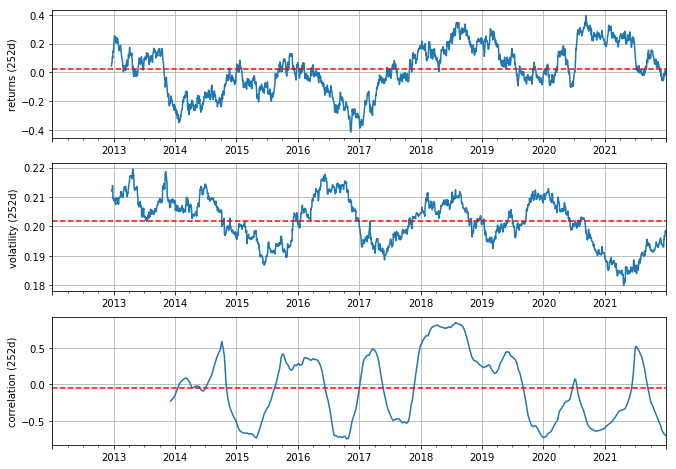

In [87]:
rolling_statistics(vol_returns)